In [33]:
import numpy as np
import pandas as pd
header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=header)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [34]:
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print str(n_users) + ' users'
print str(n_items) + ' items'

943 users
1682 items


In [35]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [36]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print 'Sparsity: {:4.2f}%'.format(sparsity)

Sparsity: 6.30%


In [37]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in xrange(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [38]:
train, test = train_test_split(ratings)

In [39]:
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [40]:
user_similarity = similarity(train, kind='user')
item_similarity = similarity(train, kind='item')

In [41]:
print item_similarity[:4, :4]

[[ 1.          0.41752284  0.30646365  0.43937771]
 [ 0.41752284  1.          0.26131218  0.49554282]
 [ 0.30646365  0.26131218  1.          0.29908712]
 [ 0.43937771  0.49554282  0.29908712  1.        ]]


In [42]:
print user_similarity[:4, :4]

[[ 1.          0.13927399  0.04101101  0.03709988]
 [ 0.13927399  1.          0.09505324  0.08652902]
 [ 0.04101101  0.09505324  1.          0.3828674 ]
 [ 0.03709988  0.08652902  0.3828674   1.        ]]


In [44]:
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [45]:
%timeit predict(train, user_similarity, kind='user')

10 loops, best of 3: 64.3 ms per loop


In [46]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [47]:
item_prediction = predict(train, item_similarity, kind='item')
user_prediction = predict(train, user_similarity, kind='user')

print 'User-based CF MSE: ' + str(get_mse(user_prediction, test))
print 'Item-based CF MSE: ' + str(get_mse(item_prediction, test))

User-based CF MSE: 8.38393424353
Item-based CF MSE: 11.4878622718


In [48]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
    if kind == 'item':
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items]))        
    
    return pred

In [49]:
pred = predict_topk(train, user_similarity, kind='user', k=40)
print 'Top-k User-based CF MSE: ' + str(get_mse(pred, test))

pred = predict_topk(train, item_similarity, kind='item', k=40)
print 'Top-k Item-based CF MSE: ' + str(get_mse(pred, test))

Top-k User-based CF MSE: 6.44780665732
Top-k Item-based CF MSE: 7.69692265112


In [50]:
def predict_topk_nobias(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    if kind == 'user':
        user_bias = ratings.mean(axis=1)
        ratings = (ratings - user_bias[:, np.newaxis]).copy()
        for i in xrange(ratings.shape[0]):
            top_k_users = [np.argsort(similarity[:,i])[:-k-1:-1]]
            for j in xrange(ratings.shape[1]):
                pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
                pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))
        pred += user_bias[:, np.newaxis]
    if kind == 'item':
        item_bias = ratings.mean(axis=0)
        ratings = (ratings - item_bias[np.newaxis, :]).copy()
        for j in xrange(ratings.shape[1]):
            top_k_items = [np.argsort(similarity[:,j])[:-k-1:-1]]
            for i in xrange(ratings.shape[0]):
                pred[i, j] = similarity[j, :][top_k_items].dot(ratings[i, :][top_k_items].T) 
                pred[i, j] /= np.sum(np.abs(similarity[j, :][top_k_items])) 
        pred += item_bias[np.newaxis, :]
        
    return pred

In [51]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

for k in k_array:
    user_pred = predict_topk_nobias(train, user_similarity, kind='user', k=k)
    item_pred = predict_topk_nobias(train, item_similarity, kind='item', k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    
    item_train_mse += [get_mse(item_pred, train)]
    item_test_mse += [get_mse(item_pred, test)]

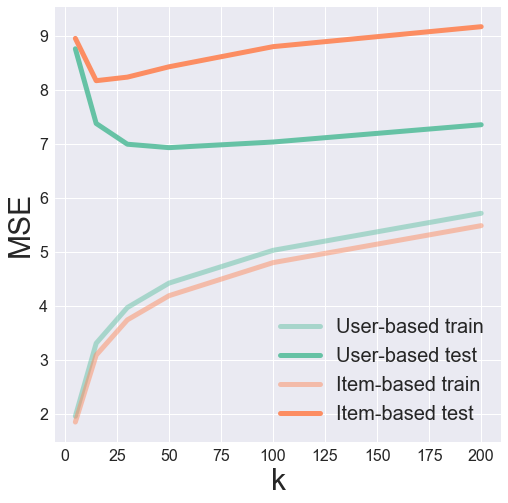

In [52]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)
plt.plot(k_array, item_train_mse, c=pal[1], label='Item-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, item_test_mse, c=pal[1], label='Item-based test', linewidth=5)
plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

In [61]:
# Load in movie data
idx_to_movie = {}
with open('ml-100k/u.item', 'r') as f:
    for line in f.readlines():
        info = line.split('|')
        idx_to_movie[int(info[0])-1] = info[4]
        
def top_k_movies(similarity, mapper, movie_idx, k=6):
    return [mapper[x] for x in np.argsort(similarity[movie_idx,:])[:-k-1:-1]]

In [67]:
idx = 0
movies = top_k_movies(item_similarity, idx_to_movie, idx)

In [68]:
display(*movies)

'http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)'

'http://us.imdb.com/M/title-exact?Star%20Wars%20(1977)'

'http://us.imdb.com/M/title-exact?Independence%20Day%20(1996)'

'http://us.imdb.com/M/title-exact?Return%20of%20the%20Jedi%20(1983)'

'http://us.imdb.com/M/title-exact?Mission:%20Impossible%20(1996)'

'http://us.imdb.com/M/title-exact?Rock,%20The%20(1996)'